# Lord Of The Rings PyRaphtory Example Notebook 🧝🏻‍♀️🧙🏻‍♂️💍

## Setup environment and download data 💾

Import all necessary dependencies needed to build a graph from your data in PyRaphtory. Download csv data from github into your tmp folder (file path: /tmp/lotr.csv).

In [1]:
pip install pyvis matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from pyraphtory.context import PyRaphtory
from pyraphtory.vertex import Vertex
from pyraphtory.spouts import FileSpout
from pyraphtory.input import *
from pyvis.network import Network
import csv
import pandas as pd
import numpy as np

!curl -o /tmp/lotr.csv https://raw.githubusercontent.com/Raphtory/Data/main/lotr.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52206  100 52206    0     0  1274k      0 --:--:-- --:--:-- --:--:-- 1274k


## Preview data  👀

In [3]:
!head /tmp/lotr.csv

Gandalf,Elrond,33
Frodo,Bilbo,114
Blanco,Marcho,146
Frodo,Bilbo,205
Thorin,Gandalf,270
Thorin,Bilbo,270
Gandalf,Bilbo,270
Gollum,Bilbo,286
Gollum,Bilbo,306
Gollum,Bilbo,308


In [4]:
filename = '/tmp/lotr.csv'

## Create a new Raphtory graph 📊

We Initialise Raphtory by creating a PyRaphtory object, and we create your new graph. We can turn on logs to see what is going on in PyRaphtory.

In [5]:
ctx = PyRaphtory.local()
graph = ctx.new_graph()

## Ingest the data into a graph 😋

We use a parsing method to parse the csv file and add the vertices and edges to the PyRaphtory graph.

In [6]:
graph = ctx.new_graph()
with open(filename, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:

        source_node = row[0]
        destination_node = row[1]
        timestamp = int(row[2])
        
        graph.add_vertex(timestamp, source_node, vertex_type="Character")
        graph.add_vertex(timestamp, destination_node, vertex_type="Character")  
        graph.add_edge(timestamp, source_node, destination_node, edge_type="Character_Co-occurence")

## Collect simple metrics 📈

Our data has been ingested by the graph object. We can now select certain attributes and metrics to display, for instance vertex name, degree, out degree and in degree. \
We can compute these metrics temporally. To do so,
1. the first step is to create temporal slices of the graph, also called **graph perspectives**. For instance, `.range(start, end, step)` filters the data from `start` to `end`, and splits it into slices of duration `step`. More functions such as `from`,`until`, `at`, `depart`, are presented in the [documentation of the DeplotedTemporalGraph object](https://docs.raphtory.com/en/master/_static/com/raphtory/api/analysis/graphview/DeployedTemporalGraph.html).
2. the second step is to specify which direction we are looking in at each time point (or **snapshot**) `t`. For instance `.past()` aggregate all older data until `t`, `.future()` aggregate all data starting from `t`. We can also use the function `.window()`, also presented in the [documentation of the DottedGraph object](https://docs.raphtory.com/en/master/_static/com/raphtory/api/analysis/graphview/DottedGraph.html). 

We can then specify which metrics we are interested in, and choose the names of the output columns.

In [7]:
from pyraphtory.graph import Row
df = graph \
      .range(1, 32674, 1000) \
      .past()  \
      .select(lambda vertex: Row(vertex.name(), vertex.degree(), vertex.out_degree(), vertex.in_degree())) \
      .to_df(["name", "degree", "out_degree", "in_degree"])

In [8]:
df.head(5)

,timestamp,name,degree,out_degree,in_degree


**Get simple insights from the data 👀**

In [9]:
print('# timetamps:', len(df.timestamp.unique()))
print('# characters:', len(df.name.unique()))

# timetamps: 0
# characters: 0


<AxesSubplot: title={'center': '# characters co-mentioned at least once until time t'}, xlabel='timestamp', ylabel='nb_characters'>

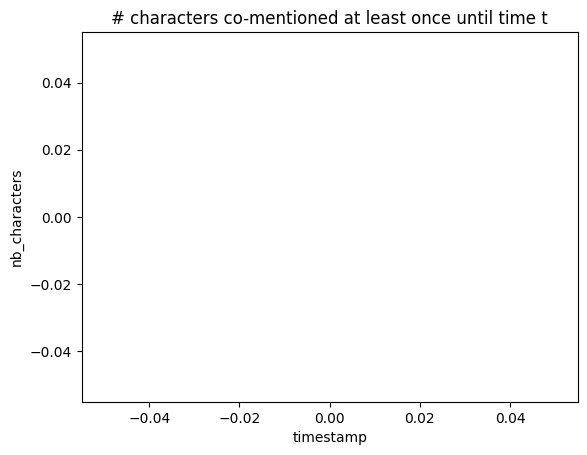

In [10]:
df \
.groupby('timestamp') \
.agg({'name': 'count'}) \
.reset_index() \
.rename(columns={'name': 'nb_characters'}) \
.plot(x='timestamp', y='nb_characters', kind='scatter', title='# characters co-mentioned at least once until time t')

**Suppose we are interested in the top 5 highest degree characters.** Because the dataframe contains the degree of each character up to each time point, we can simply look at the max degree of each character across all times.

In [11]:
df \
.groupby('name') \
.agg({'degree': 'max'}) \
.reset_index() \
.sort_values(['degree'], ascending=False)[:5]

,name,degree


**Alternatively**, we can aggregate all temporal interactions from the start, and compute the degrees on the resulting graph.

In [12]:
df = graph \
    .at(32674) \
    .past() \
    .select(lambda vertex: Row(vertex.name(), vertex.degree(), vertex.out_degree(), vertex.in_degree())) \
    .to_df(["name", "degree", "out_degree", "in_degree"])

Note that **the resulting dataframe only has one timestamp**: the final time 32674.

In [13]:
df.head(5)

,timestamp,name,degree,out_degree,in_degree
0,32674,Hirgon,2,2,0
1,32674,Hador,3,1,2
2,32674,Horn,4,1,3
3,32674,Galadriel,19,6,16
4,32674,Isildur,18,18,0


In [14]:
df.sort_values(['degree'], ascending=False)[:10]

KeyError: "['window'] not found in axis"

## Run a PageRank algorithm 📑

We can run any selected algorithm on our graph data, here we run PageRank. 
- Take the graph.
- The `transform` function applies a given algorithm to the graph, and returns the graph updated with the states that the algorithm generated. Here we apply a generic algorithm `pr.algorithms.generic.centrality.PageRank()` (PageRank) so the `transform` returns the graph where each node has now an extra attribute which is its Pagerank score.
- The `execute` function applies an algorithm (same as `transform`) AND returns the results in a tabular format (graph --> table). Here we apply the `NodeList` algorithm: it outputs one row per vertex in the graph contacted by the names in `cols`.
- We ask Raphtory to output the results in a dataframe `to_df`. 

Both functions `transform` and `execute` are explained further in the [documentation](https://docs.raphtory.com/en/master/_static/com/raphtory/api/analysis/graphview/MultilayerGraphView.html).

In [ ]:
cols = ["prlabel"]

df_pagerank = graph.at(32674) \
                .past() \
                .transform(ctx.algorithms.generic.centrality.PageRank())\
                .execute(ctx.algorithms.generic.NodeList(*cols)) \
                .to_df(["name"] + cols)

**Note: Here we run PageRank on the aggregated graph but we could, of course, have run it similarly on temporal slices as explained above.**

In [ ]:
df_pagerank.head(5)

**The top ten most ranked characters**

In [ ]:
df_pagerank.sort_values(['prlabel'], ascending=False)[:10]

## Run a connected components algorithm 

Similarly we can look for the connected components of the graph.

In [ ]:
cols = ["cclabel"]
df_cc = graph.at(32674) \
                .past() \
                .transform(ctx.algorithms.generic.ConnectedComponents)\
                .execute(ctx.algorithms.generic.NodeList(*cols)) \
                .to_df(["name"] + cols)

**Preview dataframe.**

In [ ]:
df_cc.head(5)

**Number of distinct components**

In [ ]:
print('# distinct components:', len(set(df_cc['cclabel'])))

**Calculate the size of the 3 connected components.**

In [ ]:
df_cc \
.groupby(['cclabel']) \
.count() \
.reset_index() \
.rename(columns={'name': 'size'}) \
.drop(columns=['timestamp'])

## Run chained algorithms at once 

We can also chain PageRank, Connected Components and Degree algorithms, running them one after another on the graph. Specify all the columns in the output dataframe, including an output column for each algorithm in the chain. `cols` dictates the particular order in which we want to output the result columns.

In [ ]:
cols = ["inDegree", "outDegree", "degree", "prlabel", "cclabel"]

df_chained = graph.at(32674) \
                .past() \
                .transform(ctx.algorithms.generic.centrality.PageRank())\
                .transform(ctx.algorithms.generic.ConnectedComponents)\
                .transform(ctx.algorithms.generic.centrality.Degree())\
                .execute(ctx.algorithms.generic.NodeList(*cols)) \
                .to_df(["name"] + cols)

In [ ]:
df_chained['degree_numeric'] = df_chained['degree'].astype(float)
df_chained.head(10)

## Create visualisation by adding nodes 🔎

In [ ]:
def visualise(graph, df_chained):
    # Create network object
    net = Network(notebook=True, height='750px', width='100%', bgcolor='#222222', font_color='white')
    # Set visualisation tool
    net.force_atlas_2based()
    # Get the node list 
    df_node_list = graph.at(32674) \
                .past() \
                .execute(ctx.algorithms.generic.NodeList()) \
                .to_df(['name'])
    
    nodes = df_node_list['name'].tolist()
    
    node_data = []
    ignore_items = ['timestamp', 'name', 'window']
    for node_name in nodes:
        for i, row in df_chained.iterrows():
            if row['name']==node_name:
                data = ''
                for k,v in row.iteritems():
                    if k not in ignore_items:
                        data = data+str(k)+': '+str(v)+'\n'
                node_data.append(data)
                continue
    # Add the nodes
    net.add_nodes(nodes, title=node_data, value = df_chained.prlabel)
    # Get the edge list
    df_edge_list = graph.at(32674) \
                .past() \
                .execute(ctx.algorithms.generic.EdgeList()) \
                .to_df(['from', 'to'])
    edges = []
    for i, row in df_edge_list[['from', 'to']].iterrows():
        edges.append([row['from'], row['to']])
    # Add the edges
    net.add_edges(edges)
    # Toggle physics
    net.toggle_physics(True)
    return net

In [ ]:
net = visualise(graph, df_chained)

**Show the html file of the visualisation**

In [ ]:
%%html
net.show('preview.html')

## Shut down PyRaphtory  🛑

In [ ]:
ctx.close()